In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [9]:
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


<ipython-input-10-da05d8c93669>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Machine failure', data=df, palette='viridis')


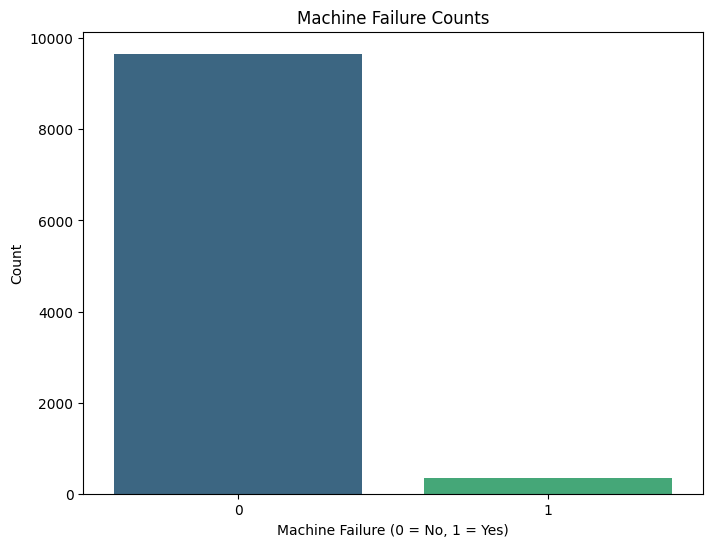

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Machine failure', data=df, palette='viridis')
plt.title('Machine Failure Counts')
plt.xlabel('Machine Failure (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [11]:
label_encoder = LabelEncoder()
df['Product_ID_encoded'] = label_encoder.fit_transform(df['Product ID'])

In [12]:
data_cleaned = df.drop(columns=['UDI', 'Product ID'])

In [13]:
X = data_cleaned.drop(columns=['Machine failure'])
y = data_cleaned['Machine failure']

In [14]:
X = pd.get_dummies(X, columns=['Type'], drop_first=True)

In [15]:
X_with_target = X.copy()
X_with_target['Machine failure'] = y

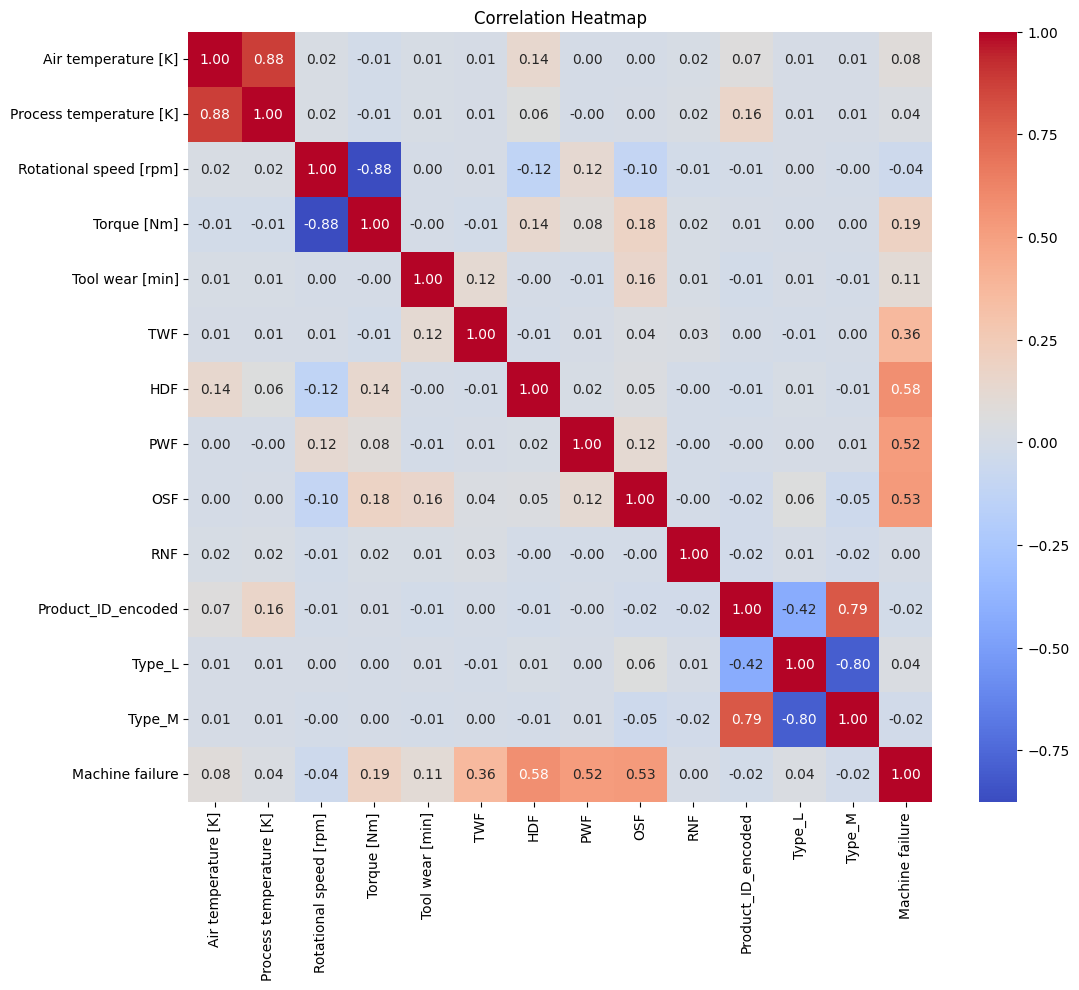

In [16]:
plt.figure(figsize=(12, 10))
correlation_matrix = X_with_target.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
X_with_target.drop(columns=['Machine failure'], inplace=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

In [21]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'solver': ['liblinear', 'saga', 'lbfgs']  # Optimization algorithms
}

In [22]:
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [23]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='accuracy', verbose=2)

In [25]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [26]:
y_pred_tuned = best_model.predict(X_test_scaled)
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
class_report_tuned = classification_report(y_test, y_pred_tuned)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

In [27]:
print("Best Parameters:", best_params)
print("\nConfusion Matrix:\n", conf_matrix_tuned)
print("\nClassification Report:\n", class_report_tuned)
print("\nAccuracy Score:", accuracy_tuned)

Best Parameters: {'C': 0.01, 'solver': 'liblinear'}

Confusion Matrix:
 [[2898    0]
 [   2  100]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2898
           1       1.00      0.98      0.99       102

    accuracy                           1.00      3000
   macro avg       1.00      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000


Accuracy Score: 0.9993333333333333


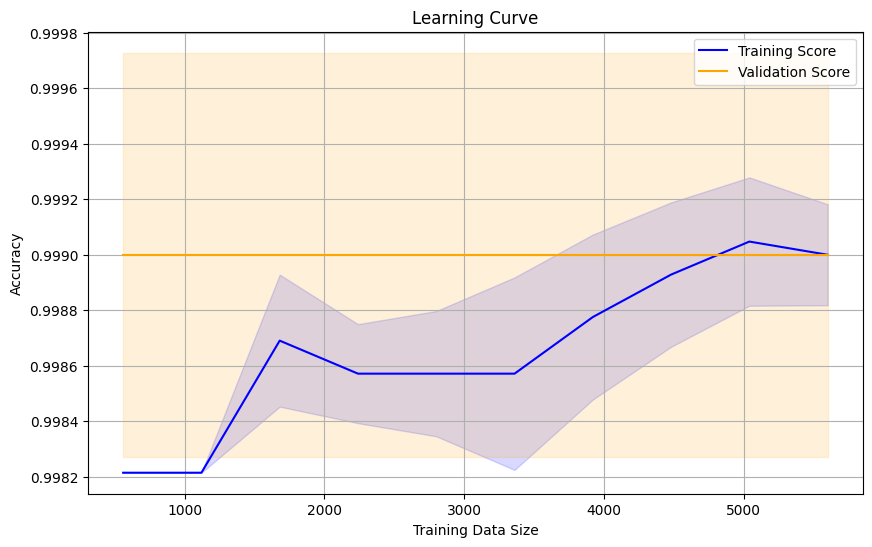

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming 'best_model', 'X_train_scaled', 'y_train' are defined from your previous code

train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_scaled,
    y_train,
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Evaluation metric
    train_sizes=np.linspace(0.1, 1.0, 10)  # Training data sizes to consider
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='orange')

plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()